In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [11]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.379050e-20,1.000578e-13,4.472464e-18,6.298579e-17,7.009529e-04,9.992990e-01
1,5.372187e-14,2.032903e-12,9.996017e-01,3.983357e-04,4.962864e-10,4.791746e-11
2,4.976088e-07,3.032208e-13,4.474790e-12,1.421738e-11,9.999991e-01,4.650143e-07
3,2.497579e-10,1.000000e+00,2.210562e-31,2.566941e-22,2.951128e-08,1.074308e-18
4,6.477347e-05,1.476087e-07,1.155804e-08,9.999330e-01,1.858218e-06,2.031066e-07


In [13]:
# min-max normalization
# predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
# predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [14]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.000000e+00,1.000578e-13,4.448673e-18,6.296200e-17,7.009529e-04,9.992990e-01,0.999299,0,Walking,Downstairs
1,0.000000e+00,1.979181e-12,9.996017e-01,3.983357e-04,4.962327e-10,4.786374e-11,0.999602,0,Sitting,Downstairs
2,4.976085e-07,0.000000e+00,4.171569e-12,1.391416e-11,9.999990e-01,4.650140e-07,0.999999,0,Upstairs,Downstairs
3,2.497579e-10,1.000000e+00,0.000000e+00,2.566941e-22,2.951128e-08,1.074308e-18,1.000000,0,Jogging,Downstairs
4,6.476192e-05,1.360507e-07,0.000000e+00,9.999331e-01,1.846660e-06,1.915486e-07,0.999933,0,Standing,Downstairs
5,1.371639e-07,4.620782e-07,2.512445e-28,0.000000e+00,7.616631e-11,9.999994e-01,0.999999,0,Walking,Downstairs
6,9.999618e-01,2.171831e-15,0.000000e+00,5.299715e-21,3.817993e-05,1.337127e-08,0.999962,0,Downstairs,Downstairs
7,9.999998e-01,4.749828e-14,4.312110e-15,0.000000e+00,1.621483e-07,1.551163e-09,1.000000,0,Downstairs,Downstairs
8,1.893737e-18,1.000000e+00,0.000000e+00,1.085395e-29,1.151480e-16,6.744480e-33,1.000000,0,Jogging,Downstairs
9,7.508221e-25,1.002405e-10,4.802358e-29,0.000000e+00,2.118648e-15,1.000000e+00,1.000000,0,Walking,Downstairs


Accuracy:  0.1028286997693335


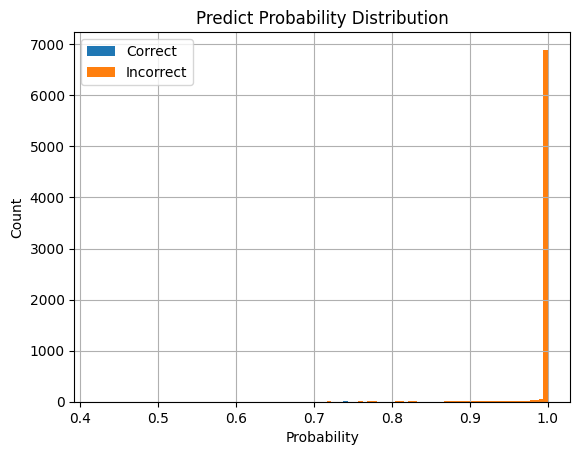

In [15]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [16]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_287740/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_287740/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_287740/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.102829,1.000000,0.000000,0.000000
0.3,0.102829,1.000000,0.000000,0.000000
0.4,0.102829,1.000000,0.000000,0.000000
0.5,0.102552,0.999150,0.428571,0.000850
0.6,0.101270,0.993808,0.352941,0.006192
0.7,0.099360,0.986039,0.347826,0.013961
